# 4. Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [4]:
df = pd.read_csv(data)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = ['gender', 'seniorcitizen', 'partner', 'dependents', 'phoneservice', 
               'multiplelines', 'internetservice', 'onlinesecurity', 'onlinebackup', 
               'deviceprotection', 'techsupport','streamingtv', 'streamingmovies', 
               'contract', 'paperlessbilling','paymentmethod']

In [7]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [10]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

# 4.2 - Accuracy and dummy model
- evaluate the model with different thresholds
- check the accuracy of dummy baselines

In [11]:
len(y_val)

1409

In [13]:
(y_val == churn_decision).sum()

1132

In [14]:
1132/1409

0.8034066713981547

In [12]:
(y_val == churn_decision).mean()

0.8034066713981547

In [20]:
# Test with different thresold values

thresholds = np.linspace(0, 1, 21)

thresholds

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [32]:
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    score = (y_val == churn_decision).mean()
    print('%.2f %.3f' % (t, score))
    scores.append(score)
    
# 0.5 is the best threshold

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


Text(0.5, 1.0, 'Scores x Thresholds')

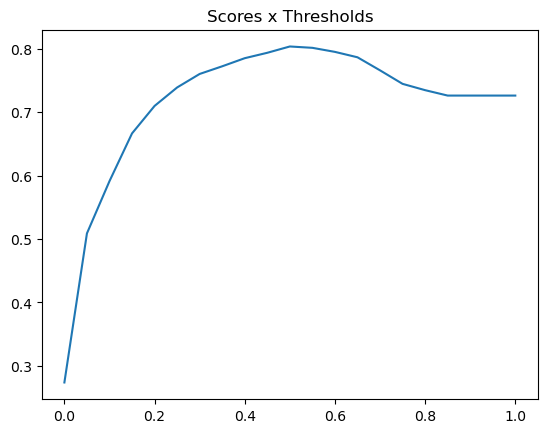

In [33]:
plt.plot(thresholds, scores)
plt.title('Scores x Thresholds')

In [34]:
# Scikit-learn has the accuracy score, which does the same of what we did

from sklearn.metrics import accuracy_score

accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [35]:
for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [38]:
# Threshold = 1.0 -> no customer will be considered as churn

from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

# 4.3 Confusion table
- Different types of errors and correct decisions
- Arranging them in a table

In [39]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [42]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [43]:
predict_positive[:10]

array([False, False, False,  True, False, False, False, False,  True,
       False])

In [44]:
actual_positive[:10]

array([False, False, False,  True, False, False, False, False,  True,
        True])

In [46]:
predict_positive & actual_positive

# - this compares the True and False values of each list
# - when both are equal, it returns True
# - if the values are different, it returns False

array([False, False, False, ..., False,  True,  True])

In [48]:
(predict_positive & actual_positive).sum()

210

In [51]:
tp = (predict_positive & actual_positive).sum() # tp = true positive
tn = (predict_negative & actual_negative).sum() # tn = true negative

In [52]:
tn

922

In [56]:
fp = (predict_positive & actual_negative).sum() # fp = false positive
fn = (predict_negative & actual_positive).sum() # fn = false negative

fp, fn

(101, 176)

In [57]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [60]:
# Confusion matrix in percentage

(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])